In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(pred):
    """
    Computes precision, recall, and F1-score for the predictions.

    Parameters:
    - pred: The output predictions from the Trainer.

    Returns:
    - A dictionary containing precision, recall, and F1-score.
    """
    predictions = pred.predictions.argmax(-1)
    labels = pred.label_ids

    # Flatten predictions and labels to ignore padding tokens (-100)
    predictions_flat = predictions.flatten()
    labels_flat = labels.flatten()

    # Remove ignored index (-100) from both predictions and labels
    valid_indices = labels_flat != -100
    predictions_flat = predictions_flat[valid_indices]
    labels_flat = labels_flat[valid_indices]

    # Calculate metrics
    tp = ((predictions_flat == labels_flat) & (labels_flat > 0)).sum()
    fp = ((predictions_flat > 0) & (predictions_flat != labels_flat)).sum()
    fn = ((predictions_flat != labels_flat) & (labels_flat > 0)).sum()

    precision = precision_score(labels_flat, predictions_flat, average="macro", zero_division=0)
    recall = recall_score(labels_flat, predictions_flat, average="macro", zero_division=0)
    f1 = f1_score(labels_flat, predictions_flat, average="macro", zero_division=0)

    # Print detailed metrics
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch
import os
from tqdm.notebook import tqdm
from joblib import dump, load

device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["WANDB_DISABLED"] = "true"

def load_dataset_from_joblib(file_path):
    dataset = load(file_path)
    print(f"Dataset loaded from {file_path}")
    return dataset

# Load the dataset
dataset = load_dataset_from_joblib("/content/drive/MyDrive/preprocessed_dataset.joblib")
dataset = dataset.remove_columns(["offset_mapping"])
# Split train/test
dataset = dataset.train_test_split(test_size=0.2)
print(dataset["train"][0])
print(type(dataset["train"][0]["input_ids"]))  # Should be list of integers

#
# # Load ClinicalBERT for token classification
model = AutoModelForTokenClassification.from_pretrained("medicalai/ClinicalBERT", num_labels=3)  # 3 = B-Symptom, I-Symptom, O

# Training setup
args = TrainingArguments(
    output_dir="/content/drive/MyDrive/results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    warmup_steps=500,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16=True,
    # logging_dir="/content/drive/MyDrive/logs",
    # dataloader_num_workers=4,
    remove_unused_columns=False  # Prevents column mismatch errors
)

data_collator = DataCollatorForTokenClassification(tokenizer)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train and evaluate
trainer.train()
trainer.evaluate()


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Dataset loaded from /content/drive/MyDrive/preprocessed_dataset.joblib
{'input_ids': [101, 25903, 131, 25923, 40167, 12013, 10161, 49619, 10198, 16587, 44374, 10107, 10493, 10465, 21559, 10108, 10220, 54047, 56859, 10162, 105377, 113, 28756, 10237, 114, 10106, 25965, 10169, 63256, 10415, 31562, 10473, 10393, 11736, 25974, 68694, 117, 11198, 15165, 12713, 15794, 20034, 10280, 10111, 120, 10345, 26981, 85833, 10108, 57254, 17440, 12563, 117, 10319, 11387, 14107, 10114, 10840, 39017, 27057, 57254, 21911, 119, 169, 10751, 71223, 172, 58577, 12772, 117, 10306, 118, 183, 14220, 15794, 40167, 12013, 10161, 113, 183, 14526, 114, 117, 10393, 10590, 19989, 10114, 10529, 11284, 81654, 40582, 119, 10531, 14687, 10134, 92311, 10114, 37284, 10105, 21274, 10108, 183, 14526, 10135, 10493, 10465, 28756, 10237, 21559, 10111, 57254, 17440, 12563, 10106, 16316, 10108, 16626, 10345, 10211, 110547, 10336, 63256, 10415, 19367, 119, 27413, 131, 104817, 67968, 10309, 16106, 10554, 28088, 74755, 81334, 18309, 1

<ipython-input-49-5de4a75e4690>:179: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.053672,0.880901,0.917916,0.898179
2,No log,0.003624,0.994337,0.994217,0.994276
3,0.169800,0.000803,0.998767,0.999216,0.998991
4,0.169800,0.000564,0.999290,0.999380,0.999335
5,0.002000,0.000337,0.999905,0.999594,0.999750
6,0.002000,0.000238,0.999887,0.999698,0.999792
7,0.000500,0.000196,0.999868,0.999805,0.999837
8,0.000500,0.000152,0.999912,0.999807,0.999860
9,0.000300,0.000135,0.999952,0.999852,0.999902
10,0.000300,0.000134,0.999952,0.999852,0.999902


True Positives (TP): 28111
False Positives (FP): 5969
False Negatives (FN): 3784
Precision: 0.88
Recall: 0.92
F1-Score: 0.90
True Positives (TP): 31629
False Positives (FP): 266
False Negatives (FN): 266
Precision: 0.99
Recall: 0.99
F1-Score: 0.99
True Positives (TP): 31859
False Positives (FP): 57
False Negatives (FN): 36
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
True Positives (TP): 31867
False Positives (FP): 32
False Negatives (FN): 28
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
True Positives (TP): 31876
False Positives (FP): 4
False Negatives (FN): 19
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
True Positives (TP): 31881
False Positives (FP): 5
False Negatives (FN): 14
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
True Positives (TP): 31886
False Positives (FP): 6
False Negatives (FN): 9
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
True Positives (TP): 31886
False Positives (FP): 4
False Negatives (FN): 9
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
True Positives (TP): 31888
False

True Positives (TP): 31888
False Positives (FP): 2
False Negatives (FN): 7
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


{'eval_loss': 0.00013405214122030884,
 'eval_precision': 0.999951640363017,
 'eval_recall': 0.9998516277263109,
 'eval_f1': 0.9999016299387892,
 'eval_runtime': 2.7193,
 'eval_samples_per_second': 718.923,
 'eval_steps_per_second': 45.231,
 'epoch': 10.0}

In [ ]:
import torch

# Example data
example = {
    "Passage": "The patient showed symptoms of anemia and was treated with iron supplements.",
    "Start Offset": 29,
    "End Offset": 35,  # The entity "anemia"
}

# Tokenize the example
tokenized_example = tokenizer(
    example["Passage"],
    truncation=True,
    padding="max_length",
    max_length=256,
    return_offsets_mapping=True,
)

# Extract offset mapping and input IDs
offset_mapping = tokenized_example.pop("offset_mapping")
input_ids = tokenized_example["input_ids"]

# Assign labels using offsets
labels = [0] * len(offset_mapping)  # Default to 'O' (outside the entity)

current_entity = False
for idx, (start, end) in enumerate(offset_mapping):
    # Ignore special tokens with (0, 0) offsets
    if start == 0 and end == 0:
        continue

    # Check if token is part of the entity
    if start >= example["Start Offset"] and end <= example["End Offset"]:
        if not current_entity:
            labels[idx] = 1  # B-Symptom (beginning of the entity)
            current_entity = True
        else:
            labels[idx] = 2  # I-Symptom (inside the entity)
    elif current_entity and start > example["End Offset"]:
        current_entity = False

# Replace padding token labels with -100 to ignore during training
labels = [
    label if token_id != tokenizer.pad_token_id else -100
    for token_id, label in zip(input_ids, labels)
]

# Add labels back to the tokenized example
tokenized_example["labels"] = labels

# Convert the tokenized example into a batch format
batch = {key: torch.tensor([value]).to("cuda" if torch.cuda.is_available() else "cpu") for key, value in tokenized_example.items()}

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Perform prediction
model.eval()
with torch.no_grad():
    output = model(**batch)

# Get predictions
predictions = output.logits.argmax(dim=-1).squeeze().tolist()
tokens = tokenizer.convert_ids_to_tokens(batch["input_ids"].squeeze().tolist())

# Print tokens, predictions, and labels
print("Tokens:", tokens)
print("Predictions:", predictions)
print("Labels:", labels)


Tokens: ['[CLS]', 'the', 'patient', 'showed', 'symptoms', 'of', 'ane', '##mia', 'and', 'was', 'treated', 'with', 'iron', 'supplement', '##s', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

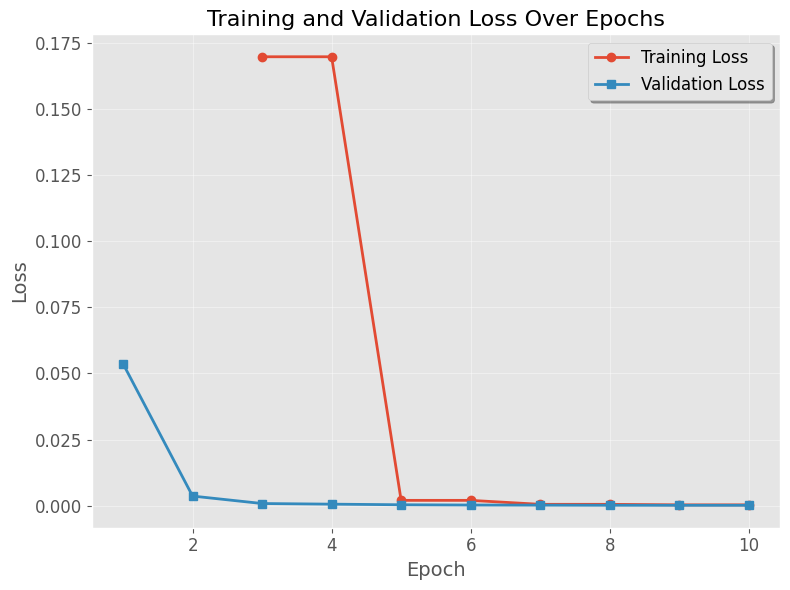

In [72]:

import matplotlib.pyplot as plt

# Data for the visualization
epochs = list(range(1, 11))
training_loss = [None, None, 0.169800, 0.169800, 0.002000, 0.002000, 0.000500, 0.000500, 0.000300, 0.000300]
validation_loss = [0.053672, 0.003624, 0.000803, 0.000564, 0.000337, 0.000238, 0.000196, 0.000152, 0.000135, 0.000134]

# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(epochs[2:], training_loss[2:], label="Training Loss", marker="o", linewidth=2, markersize=6)
plt.plot(epochs, validation_loss, label="Validation Loss", marker="s", linewidth=2, markersize=6)

# Adding titles and labels
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right", frameon=True, shadow=True)
plt.grid(alpha=0.4)
plt.tight_layout()

# Display the visualization
plt.show()
